In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, filters
from skimage.measure import label
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# CSV file containing 'genuine' and 'forged' images
train_dataset = pd.read_csv(r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train_data.csv", header = None)
test_dataset = pd.read_csv(r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\test_data.csv", header = None)
#Directory containing 'genuine' and 'forged' images
train_dir = r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train"
test_dir = r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\test"

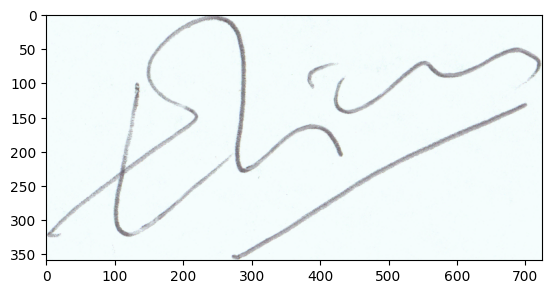

In [6]:
img = plt.imread(r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train\real\001\001_01.PNG")
plt.imshow(img)

In [7]:
# Load the image using OpenCV (replace 'image_path' with the path to your image)
image_path = r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train\001\001_01.PNG"

In [8]:
# Define a function to preprocess a single image
def preprocess_image(image_path, target_size=(128, 128), save_path=None):
        
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Resize the image
    image_resized = cv2.resize(image, target_size)
    
    # Step 2: Apply Gaussian Blur to reduce noise
    image_blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
    
    # Step 3: Apply Otsu's thresholding to convert to binary
    threshold_value = filters.threshold_otsu(image_blurred)
    binary_image = image_blurred > threshold_value
    
    # Step 4: Label connected regions in the binary image
    labeled_image = label(binary_image)
    
    # Step 5: Normalize the image (scale pixel values to range [0, 1])
    normalized_image = image_resized.astype('float32') / 255.0
    
    # Step 6: Convert to RGB (3 channels) 
    rgb_image = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    
    # Save the processed image if a save path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, rgb_image)
    
    return {
        "original": image,
        "binary": binary_image,
        "normalized": normalized_image,
        "rgb": rgb_image
    }

In [9]:
# Define a function to preprocess all images in a directory
def preprocess_dataset(input_dir, output_dir, target_size=(128, 128)):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                
                # Define save path for preprocessed image
                relative_path = os.path.relpath(image_path, input_dir)
                save_path = os.path.join(output_dir, relative_path)
                
                # Preprocess the image and save
                preprocess_image(image_path, target_size, save_path)

In [10]:
# Define paths for input and output directories
input_dir = r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train"
output_dir = r"C:\Users\HP\Desktop\jupyter projects\archive\preprocessed_images"

In [11]:
# Preprocess the entire dataset
preprocess_dataset(input_dir, output_dir)

In [12]:
# Verify the output by checking some images
sample_image_path = os.path.join(output_dir, '001_forg', '0119001_01.png')
processed_images = preprocess_image(sample_image_path)

In [13]:
# Plot the processed images to verify
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

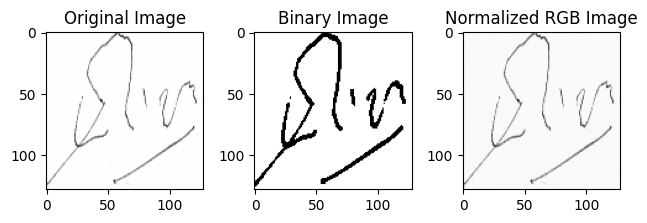

In [14]:
# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(processed_images["original"], cmap='gray')
plt.title('Original Image')

# Display the binary image
plt.subplot(1, 3, 2)
plt.imshow(processed_images["binary"], cmap='gray')
plt.title('Binary Image')

# Display the normalized RGB image
plt.subplot(1, 3, 3)
plt.imshow(processed_images["rgb"])
plt.title('Normalized RGB Image')

plt.tight_layout()
plt.show()

In [15]:
class CustomImageLoader(Sequence):
    def __init__(self, csv_file, image_dir, batch_size, target_size, **kwargs):
        # Initialize the parent class (Sequence)
        super().__init__(**kwargs)  # This ensures that any arguments passed to the parent class are handled properly

        # Load the dataset CSV and store the image directory and parameters
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        # Calculate the number of batches per epoch
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        # Get the batch of data
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []
        for _, row in batch_data.iterrows():
             # Read the image file from disk
            image_path = row['image_path']
            label = row['label']
            img = cv2.imread(f"{self.image_dir}/{image_path}")
            img = cv2.resize(img, self.target_size)
            images.append(img)
            labels.append(label)

         # Convert lists to numpy arrays and return the batch
        return np.array(images), np.array(labels)

In [16]:
train_loader = CustomImageLoader(
    csv_file=r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train_data.csv",
    image_dir=r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train",
    batch_size=16,
    target_size=(150, 150),
    workers=4,  # Example of additional argument for parallelism
    use_multiprocessing=True
)

In [17]:
# Define the generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Load images directly from the directories
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\train",
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    r"C:\Users\HP\Desktop\jupyter projects\archive\sign_data\test",
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

Found 917 images belonging to 2 classes.
Found 732 images belonging to 2 classes.


In [19]:
# Load the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [20]:
# Unfreeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = True  # Allow training of all layers

In [21]:
# Add custom layers on top for binary classification
x = base_model.output # This is a Keras tensor
x = Flatten()(x) # Flatten the output from the base model
x = Dense(512, activation='relu')(x) # Add a dense layer
x = Dropout(0.5)(x) # Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification (output layer) (genuine vs. forged)

In [22]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile and train
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust the number of epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.5515 - loss: 0.7495 - val_accuracy: 0.6236 - val_loss: 0.6285
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8125 - loss: 0.5719

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8125 - loss: 0.5719 - val_accuracy: 0.8333 - val_loss: 0.5385
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7488 - loss: 0.5277 - val_accuracy: 0.9472 - val_loss: 0.1571
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8750 - loss: 0.4370 - val_accuracy: 0.9167 - val_loss: 0.3283
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8825 - loss: 0.2738 - val_accuracy: 0.9472 - val_loss: 0.1374
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9375 - loss: 0.0862 - val_accuracy: 0.9167 - val_loss: 0.1086
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9416 - loss: 0.1527 - val_accuracy: 0.9778 - val_loss: 0.0593
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9167 - val_loss: 0.1931
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9500 - loss: 0.1539 - val_accuracy: 0.9528 - val_loss: 0.0913

In [25]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Accuracy: {accuracy:.2f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.9720 - loss: 0.0695
Accuracy: 0.97


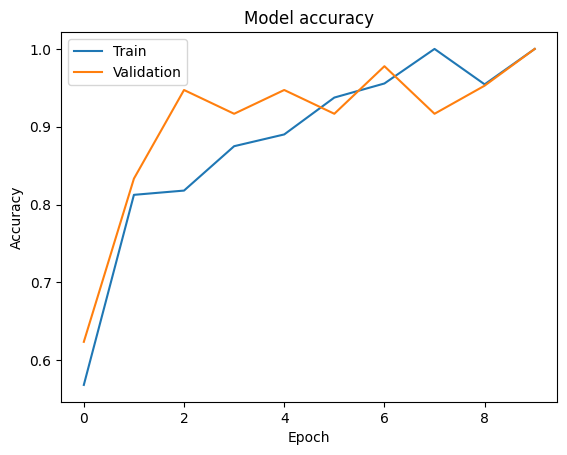

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

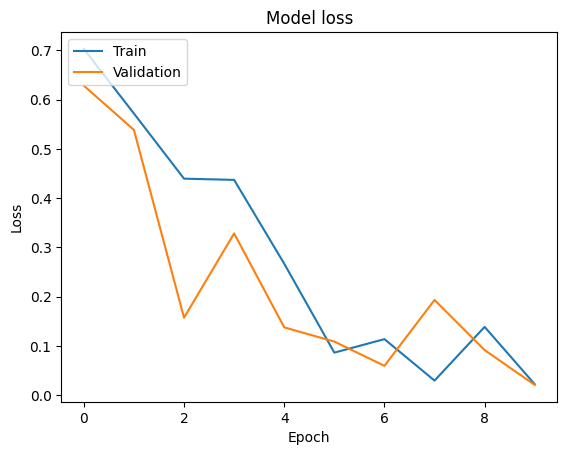

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
# Save the model using the recommended Keras format
from tensorflow.keras.models import load_model

model.save('forge_real_signature_model.keras')

In [29]:
pred = model.predict(test_generator)
pred

46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 494ms/step


array([[9.97801065e-01],
       [1.47718787e-01],
       [1.91577801e-05],
       [6.56446442e-04],
       [3.18747386e-02],
       [2.73837009e-04],
       [6.58412432e-07],
       [9.82297361e-01],
       [9.97894943e-01],
       [8.02585146e-06],
       [9.48064566e-01],
       [9.96076524e-01],
       [9.25589085e-01],
       [7.31216297e-02],
       [1.30122349e-01],
       [9.98819232e-01],
       [9.98018920e-01],
       [8.76947961e-05],
       [9.94640112e-01],
       [9.98953879e-01],
       [1.50408552e-04],
       [1.05703538e-02],
       [9.98738170e-01],
       [9.89122391e-01],
       [9.98142898e-01],
       [4.33723330e-01],
       [9.99089599e-01],
       [5.42204020e-07],
       [3.02596996e-03],
       [9.98504519e-01],
       [7.14761317e-01],
       [9.98334825e-01],
       [9.97104585e-01],
       [3.68065230e-07],
       [9.29529720e-04],
       [4.90576553e-04],
       [9.98391151e-01],
       [9.99250650e-01],
       [9.97261524e-01],
       [7.47159645e-02],


In [30]:
model = load_model('forge_real_signature_model.keras')

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load your trained CNN model (replace 'path/to/your/model' with your actual model path)
cnn_model = tf.keras.models.load_model('forge_real_signature_model.keras')

In [32]:
# Function to preprocess and predict features for an image using the CNN model
def extract_features(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    # Get feature vector (assumes you use the second-to-last layer as features)
    feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = feature_extractor.predict(img_array)
    return features.flatten()  # Flatten to 1D array

In [33]:
# Paths to the images you want to compare
image1_path = r'C:\Users\HP\Desktop\jupyter projects\archive\sign_data\test\real2\039\01_039.png'
image2_path = r'C:\Users\HP\Desktop\jupyter projects\archive\sign_data\test\real2\039\02_039.png'

In [34]:
# Extract features from both images
features1 = extract_features(image1_path, cnn_model)
features2 = extract_features(image2_path, cnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


In [35]:
# Prepare features for SVM (pair-wise comparison)
X = np.vstack([features1, features2])
y = [0, 1]  # Labels: 0 

In [36]:
# Standardize the features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Train an SVM classifier
svm = SVC(kernel='linear', probability=True)  # You can experiment with other kernels (e.g., 'rbf')
svm.fit(X_scaled, y)

SVC(kernel='linear', probability=True)

In [38]:
# Prediction: Comparing the two images
prediction = svm.predict([X_scaled[0]])
probabilities = svm.predict_proba([X_scaled[0]])

In [39]:
print(f"Prediction (0 = Genuine, 1 = Forged): {prediction[0]}")
print(f"Probabilities: {probabilities}")

Prediction (0 = Genuine, 1 = Forged): 0
Probabilities: [[0.33333332 0.66666668]]
